In [1]:
import torch
import numpy as np
import normflows as nf

data_seed = 12
seed = 123
torch.manual_seed(seed)
torch.no_grad()
N=2**10

import sys
import os
c_directory = os.getcwd()
sys.path.append(os.path.dirname(c_directory))
sys.path.append(os.path.join(os.path.dirname(c_directory), 'FCYeast'))
import FC3_simulator
import architecture


from matplotlib import pyplot as plt
enable_cuda = True
CUDA_LAUNCH_BLOCKING=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [2]:
target = FC3_simulator.target()
context_size = 4

#latent_size = 1
#hidden_units = 128
#hidden_layers = 5



/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:63: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.prior = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))
/home/pessoa/Codes/SBIFC-inference/FCYeast3/FC3_simulator.py:64: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.params_dist = torch.distributions.MultivariateNormal(torch.tensor(means).clone().detach().to(device), torch.diag(torch.tensor(sigmas)**2).clone().detach().to(device))


In [3]:
dils_str = ['12','23','33']
dils = [.12,.23,.33]
models=[]

for dil in dils_str:
    model = architecture.make_model()
    model_file = 'dilution{}/FCYeast_network.pt'.format(dil)
    model.load_state_dict(torch.load(model_file))
    
    for param in model.parameters():
        param.requires_grad = False
    models.append(model)


In [4]:
X = np.loadtxt('FC3_synth/synth_{}.csv'.format(data_seed)).astype(np.float32)
x = [torch.tensor(X[:,i]).reshape(-1,1).to(device)[:N] for i in range(3)]

In [5]:
def logprior(params):
    return target.prior.log_prob(params)

vectorize_params = [torch.ones(xi.size(0),5).to(device) for xi in x]

def log_likelihood(data,params,models):
    global vectorize_params

    lp = []
    for (data_sub,params_sub,vec_params_sub,model_sub) in zip(data,params,vectorize_params,models):
        if data_sub.size !=  vec_params_sub.size(0):
            vec_params_sub = torch.ones((data_sub.size(0),4),device=device)
        lp.append(model_sub.log_prob(data_sub,params_sub*vec_params_sub))

    return lp

def log_post(data,params,models,lprior=logprior):
    return sum([lp.sum() for lp in log_likelihood(data,FC3_simulator.transform_to_arbitrary(params),models)]) + lprior(params)

In [6]:
gt = np.loadtxt('FC3_synth/gt_map.csv').astype(np.float32)
gt = torch.tensor(gt[gt[:,0]==data_seed][0,1:],device=device)
gt

tensor([ 6.5724, -1.3780, -0.0546, -2.0742,  0.7858, -1.0884, -2.5799, -0.9336,
         0.0479, -2.3422], device='cuda:0')

In [7]:
log_post(x,gt,models)

tensor(-1726.6125, device='cuda:0')

In [8]:
params_100 = target.prior.sample((1000,))
best_param = params_100[0]
lp_max = log_post(x,best_param,models)

for par in params_100[1:]:
    lp_par = log_post(x,par,models)
    if lp_par>lp_max:
        best_param = par
        lp_max=lp_par
        print(best_param,lp_max)

for i in range(3,8):
    print(i)
    for par in (1/i)*(params_100-best_param) + best_param:
        lp_par = log_post(x,par,models)
        if lp_par>lp_max:
            best_param = par
            lp_max=lp_par
            print(best_param,lp_max)


del params_100

tensor([ 9.3703,  0.4809, -1.2309, -0.5099,  1.0566, -0.9747, -1.9215, -1.6100,
         1.9319, -2.1493], device='cuda:0') tensor(-7453.1338, device='cuda:0')
tensor([ 6.0352,  0.2668,  0.9038, -1.4396, -0.0901, -0.0742, -1.5449,  0.6190,
         0.7165, -1.1352], device='cuda:0') tensor(-1757.9432, device='cuda:0')
tensor([ 6.7208e+00,  1.3967e+00,  2.3815e+00,  2.8999e-03, -6.0220e-02,
        -1.1439e+00, -3.0393e+00, -5.3947e-01, -2.3698e-01, -2.4334e+00],
       device='cuda:0') tensor(-1733.3154, device='cuda:0')
tensor([ 6.7272,  0.2876,  1.2379, -0.3367,  0.6381,  0.6909, -1.6237, -0.4025,
         0.5542, -2.3635], device='cuda:0') tensor(-1732.5278, device='cuda:0')
3
tensor([ 7.0803,  0.1858,  1.3573, -0.5007,  0.3776,  0.4073, -2.3354, -0.4418,
         0.7583, -2.7463], device='cuda:0') tensor(-1730.9823, device='cuda:0')
tensor([ 7.1928, -0.2459,  1.0375, -0.7357, -0.0688, -0.1372, -1.4014, -0.5875,
         0.2376, -1.7183], device='cuda:0') tensor(-1726.7571, device='

KeyboardInterrupt: 

In [ ]:
param = best_param
lp = lp_max

sampled_params = [param.cpu()]
sampled_logpost = [lp.cpu().item()]

In [ ]:
S = torch.eye(10)*1e-4
mvn = torch.distributions.MultivariateNormal(torch.zeros(10,device=device),S.to(device))

def change_S(newS):
    global S
    global mvn

    S = newS
    mvn = torch.distributions.MultivariateNormal(torch.zeros(10,device=device),S.to(device))

def proposal(param):
    return param + mvn.sample()

In [ ]:
count_of_safe=0
loopruns = 0

while count_of_safe <=15:
    for i in range(150):
        param_prop = proposal(param)
        lp_prop = log_post(x,param_prop,models)

        if torch.log(torch.rand(1))< (lp_prop-lp).item():
            param = param_prop
            lp = lp_prop

        sampled_params.append(param.cpu())
        sampled_logpost.append(lp.cpu().item())

        #print(param_prop)

    acc_rate = np.mean([(sampled_params[i] - sampled_params[i-1]).sum().item()!=0 for i in range(-1,-101,-1)])

    if acc_rate>.2 and acc_rate<.5:
        count_of_safe += 1
    else:
        count_of_safe = 0

    if loopruns%3==2:
        change_S( (torch.stack(sampled_params[-200:]).T.cov() + torch.eye(10)*1e-8) * (2.4**2/(10)) )
    loopruns+=1

    print(loopruns,acc_rate, '    ', sampled_logpost[-1])
    



1 0.89      -1723.06103515625
2 0.95      -1722.0223388671875
3 0.97      -1721.6534423828125
4 0.74      -1723.276123046875
5 0.72      -1722.140380859375
6 0.85      -1724.21923828125
7 0.6      -1726.3485107421875
8 0.57      -1724.8511962890625
9 0.7      -1725.12646484375
10 0.37      -1722.30517578125
11 0.36      -1723.677001953125
12 0.3      -1727.247314453125
13 0.25      -1721.6002197265625
14 0.39      -1725.1658935546875
15 0.36      -1722.2476806640625
16 0.44      -1722.899169921875
17 0.49      -1725.8193359375
18 0.41      -1723.120361328125
19 0.48      -1727.65283203125
20 0.42      -1725.5174560546875
21 0.28      -1722.6781005859375
22 0.43      -1722.916015625
23 0.38      -1728.7664794921875
24 0.46      -1726.6337890625
25 0.32      -1727.774169921875


In [ ]:
burnin = len(sampled_logpost)
for i in range(100000):
    param_prop = proposal(param)
    lp_prop = log_post(x,param_prop,models)

    if torch.log(torch.rand(1))< (lp_prop-lp).item():
        param = param_prop
        lp = lp_prop

    sampled_params.append(param.cpu())
    sampled_logpost.append(lp.cpu().item())

    if i%100 == 99:
        print(i,param,lp)
        #print(i,param,lp)

99 tensor([ 6.5070, -0.8198,  0.3494, -1.8596,  0.9378,  0.4739, -2.2971, -2.2162,
        -0.0262, -2.3777], device='cuda:0') tensor(-1727.5911, device='cuda:0')
199 tensor([ 6.4453, -0.2916,  0.6809, -1.7809,  1.3879,  0.3109, -2.1848,  0.1250,
         0.0347, -2.5349], device='cuda:0') tensor(-1728.0237, device='cuda:0')
299 tensor([ 6.1359,  0.2503,  0.3233, -2.8784,  2.3485,  0.7660, -2.0669, -0.1672,
         0.5170, -2.5320], device='cuda:0') tensor(-1727.1682, device='cuda:0')
399 tensor([ 5.9130,  0.4913, -0.7093, -2.3641,  2.4767,  0.6118, -2.1487, -0.3913,
         1.3276, -2.5776], device='cuda:0') tensor(-1730.1283, device='cuda:0')
499 tensor([ 6.0755,  0.0622, -0.3668, -2.9024,  2.4368,  0.0248, -2.6451, -1.2913,
        -1.7675, -2.2904], device='cuda:0') tensor(-1731.0150, device='cuda:0')
599 tensor([ 6.0230,  0.1437, -0.1541, -2.3708,  2.5583, -0.0147, -2.9475, -0.0254,
        -0.8772, -1.6060], device='cuda:0') tensor(-1730.3818, device='cuda:0')
699 tensor([ 5.36

KeyboardInterrupt: 

In [ ]:
np.savetxt('FC3_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed,data_seed,N),
           np.hstack((np.stack(sampled_params), np.array(sampled_logpost).reshape(-1,1))))

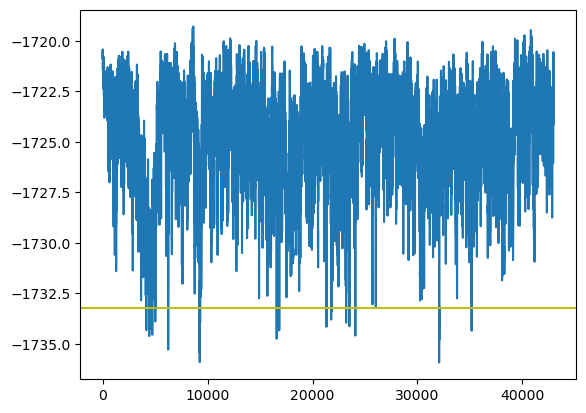

In [ ]:
plt.plot(sampled_logpost)
plt.axhline(log_post(x,gt,models).cpu().numpy(),color='y')

In [ ]:
#this still does a single n, please fix

def grid_plot(x,param,model):
    xp = torch.linspace(x.min(),x.max(),101).to(device)
    lp = model.log_prob(xp.reshape(-1,1),torch.ones((101,4),device=device)*param)
    p = torch.exp(lp-lp.max())
    p *= 1/(p.sum()*(xp[1]-xp[0]))
    return xp.cpu(),p.cpu()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


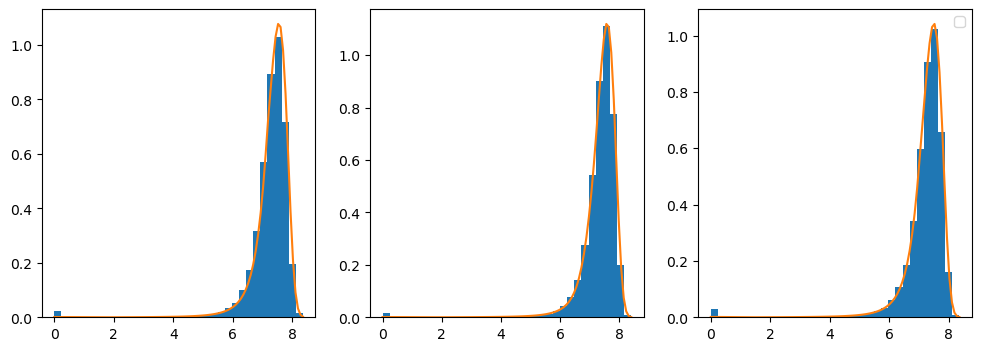

In [ ]:
#x_all = X = np.loadtxt('FCYeast3_synth/synth_{}.csv'.format(data_seed)).astype(np.float32)
x_all = [torch.tensor(X[:,i]).reshape(-1,1).to(device)[:-1] for i in range(3)]
fig,ax = plt.subplots(1,3,figsize=(12,4))
[axi.hist(xi.cpu().numpy().reshape(-1) ,density=True,bins=35) for (axi,xi) in zip(ax,x_all)]
params = FC3_simulator.transform_to_arbitrary(best_param)
[axi.plot(*grid_plot(xi,parami,model)) for (xi,parami,axi) in zip(x_all,params,ax)]

x

plt.legend()

In [ ]:
'FC3_mcmc/results_{}seed_{}data_{}dp.csv'.format(seed,data_seed,N),

('FC3_mcmc/results_123seed_12data_1024dp.csv',)